In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import librosa
import librosa.display
from IPython import display
from copy import deepcopy

# the pra library
import pyroomacoustics as pra

In [2]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

### Load sound

In [3]:
hello = Audio.fromfile("hello.wav")
print(hello.rate)
print(len(hello.data))
hello.play()

44100
252864


/Users/mac/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [4]:
orgdata = hello.data
orgdata.shape, orgdata

((252864,),
 array([ 0.01644897,  0.01644897,  0.01654053, ..., -0.00338745,
        -0.00326538, -0.00292969], dtype=float32))

In [5]:
byebye = Audio(Audio.fromfile("byebye.wav").data[:len(hello.data)], hello.rate)
print(len(byebye.data))
byebye.play()

252864


/Users/mac/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Beamforming

###  one-line mics

/Users/mac/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/pyroomacoustics/room.py:1525: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = a3.Axes3D(fig)


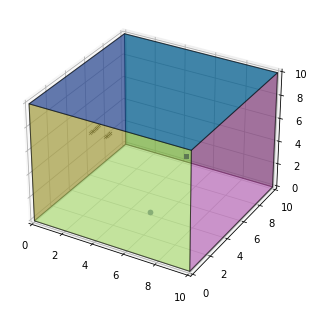

In [6]:
'''Room Parameters and Room Creation'''
room_dim = [10, 10, 10] # meters
m = pra.Material(energy_absorption="panel_fabric_covered_6pcf")
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=m, max_order=0) #simulate perfect situation: no reflections

'''Sound Source Creation'''
room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1) # inference 2?

'''Mic Array Creation'''
mic_locs = np.c_[
    [1, 4.5, 5],
    [1, 4.6, 5],
    [1, 4.7, 5],
    [1, 4.8, 5],
    [1, 4.9, 5],
    [1, 5, 5],
    [1, 5.1, 5],
    [1, 5.2, 5],
    [1, 5.3, 5],
    [1, 5.4, 5],
    [1, 5.5, 5],
    [2, 4.5, 5],
    [2, 4.6, 5],
    [2, 4.7, 5],
    [2, 4.8, 5],
    [2, 4.9, 5],
    [2, 5, 5],
    [2, 5.1, 5],
#     [2, 5.2, 5],
#     [2, 5.3, 5],
#     [2, 5.4, 5],
#     [2, 5.5, 5]
    
]


# filter size (???)
Lg_t = 0.1 # filter size in seconds
Lg = np.ceil(Lg_t*room.fs)


# place the beamforming micarray in the room (the beamforming class is a child class of the micarray class)
fft_len = 512
mics = pra.Beamformer(mic_locs, room.fs, N=fft_len, Lg=Lg)
room.add_microphone_array(mics)


# Compute DAS (delay and sum) weights
mics.rake_delay_and_sum_weights(room.sources[0])

'''Simulation'''
room.compute_rir()
room.simulate()


fig, ax = room.plot()

In [7]:
### Original_mixed ###
original_signal = room.mic_array.signals[0, :]
mixdata = Audio(original_signal, room.fs).data
Audio(original_signal, room.fs).play()

In [8]:
### Beamformed ###
resulted_signal = mics.process()
bfdata = Audio(resulted_signal, room.fs).data
Audio(resulted_signal, room.fs).play()

### evaluation

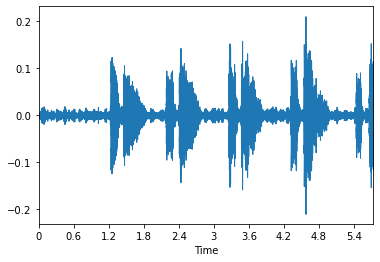

In [9]:
## byebyte.wav
byebye.plot_wave()

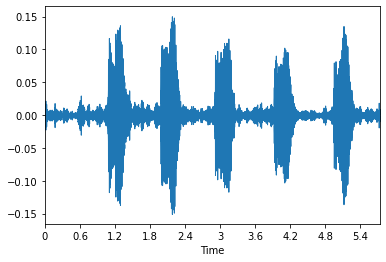

In [10]:
## hello.wav
hello.plot_wave()

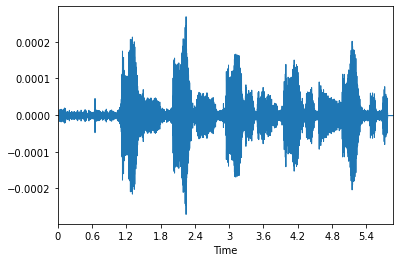

In [11]:
## BF
Audio(resulted_signal, room.fs).plot_wave()

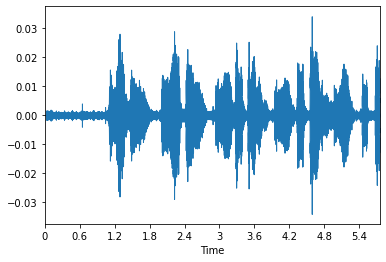

In [12]:
## Mix
Audio(original_signal, room.fs).plot_wave()

In [13]:
# SNR with power
length = min(len(orgdata), len(bfdata), len(mixdata))

orgnorm = (orgdata/np.linalg.norm(orgdata))[:length]
bfnorm = (bfdata/np.linalg.norm(bfdata))[:length]
mixnorm = (mixdata/np.linalg.norm(mixdata))[:length]


noise_bf = bfnorm - orgnorm
noise_mix = mixnorm - orgnorm


# # power
bf_power = np.sum(bfnorm*bfnorm)/len(bfnorm)
noise_bf_power = np.sum(noise_bf*noise_bf)/len(noise_bf)

mix_power = np.sum(mixnorm*mixnorm)/len(mixnorm)
noise_mix_power = np.sum(noise_mix*noise_mix)/len(noise_mix)

org_power = np.sum(orgnorm*orgnorm)/len(orgnorm)

# SNR
SNR_bf = bf_power / noise_bf_power
SNR_mix = mix_power / noise_mix_power


SNR_bf, SNR_mix,noise_bf_power

(0.4785936762493676, 0.4520374519960911, 8.248679982545109e-06)

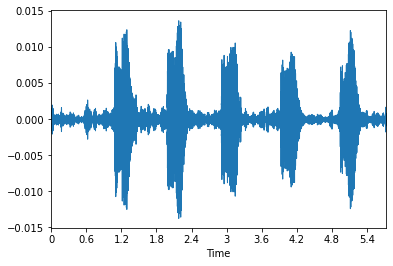

In [14]:
Audio(orgnorm, room.fs).plot_wave()

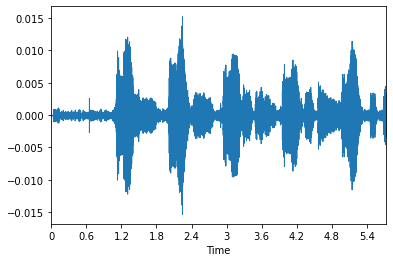

In [15]:
Audio(bfnorm, room.fs).plot_wave()

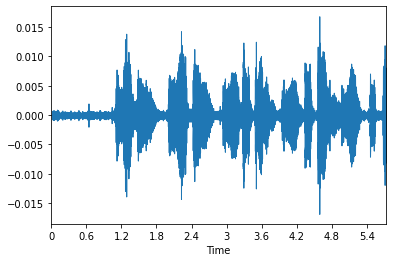

In [16]:
Audio(mixnorm, room.fs).plot_wave()

In [17]:
bfnorm1 = bfnorm[:]

In [18]:
ary = (orgnorm, bfnorm, mixnorm)
ary

(array([ 0.00149501,  0.00149501,  0.00150333, ..., -0.00030788,
        -0.00029678, -0.00026627], dtype=float32),
 array([ 1.31956809e-13, -1.99771272e-13,  3.77744777e-13, ...,
         3.58177348e-04,  3.56404694e-04,  3.58499943e-04]),
 array([-2.96075525e-10,  1.84338718e-11, -5.22698395e-10, ...,
        -2.52910803e-03, -3.02395071e-03, -3.52095822e-03]))

In [19]:
#### use PCA to compare the similarity of two spectra
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# PCA to plot
DataBF = pd.DataFrame(data=ary)
DataBF

0             1             2             3             4       \
0  1.495006e-03  1.495006e-03  1.503327e-03  1.497779e-03  1.519969e-03   
1  1.319568e-13 -1.997713e-13  3.777448e-13 -7.290474e-13  8.740660e-13   
2 -2.960755e-10  1.843387e-11 -5.226984e-10 -1.855716e-10 -3.828632e-10   

         5             6             7             8             9       ...  \
0  1.500553e-03  1.472816e-03  1.470043e-03  1.447853e-03  1.420117e-03  ...   
1 -7.886047e-13  1.007312e-12 -1.311348e-12  9.884477e-13 -1.235356e-12  ...   
2 -2.093226e-11  1.297223e-10 -4.995286e-10  1.626184e-11  5.577448e-10  ...   

     252854    252855    252856    252857    252858    252859    252860  \
0 -0.000361 -0.000358 -0.000374 -0.000383 -0.000361 -0.000347 -0.000330   
1  0.000534  0.000492  0.000458  0.000413  0.000390  0.000384  0.000365   
2  0.000334  0.000072 -0.000313 -0.000731 -0.001162 -0.001623 -0.002073   

     252861    252862    252863  
0 -0.000308 -0.000297 -0.000266  
1  0.000358  0.000356  0.000358  
2 -0.002529 -0.003024 -0.003521  

[3 rows x 252864 columns]

In [20]:
scaler = StandardScaler()
DataBF = scaler.fit_transform(ary)
df = pd.DataFrame(data=DataBF)
df

0         1         2         3         4         5         6       \
0  1.414214  1.414214  1.414214  1.414214  1.414214  1.414214  1.414214   
1 -0.707107 -0.707107 -0.707106 -0.707107 -0.707107 -0.707107 -0.707107   
2 -0.707107 -0.707107 -0.707107 -0.707107 -0.707107 -0.707107 -0.707107   

     7         8         9       ...    252854    252855    252856    252857  \
0  1.414214  1.414214  1.414214  ... -1.381970 -1.229084 -0.786678 -0.311870   
1 -0.707106 -0.707107 -0.707107  ...  0.951021  1.220359  1.411108  1.350528   
2 -0.707107 -0.707107 -0.707106  ...  0.430950  0.008725 -0.624430 -1.038658   

     252858    252859    252860    252861    252862    252863  
0  0.027116  0.219317  0.340559  0.419951  0.472203  0.515437  
1  1.210962  1.100269  1.018424  0.959524  0.918354  0.882783  
2 -1.238078 -1.319586 -1.358982 -1.379476 -1.390557 -1.398220  

[3 rows x 252864 columns]

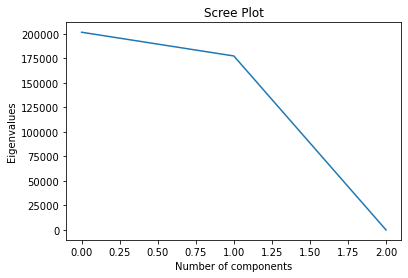

array([[-3.16746575e+01,  4.85624992e+02,  2.35336105e-12],
       [-4.32501487e+02, -2.68544160e+02,  2.35336105e-12],
       [ 4.64176145e+02, -2.17080831e+02,  2.35336105e-12]])

<Figure size 432x288 with 0 Axes>

In [21]:
pca = PCA()
pc = pca.fit_transform(df)
eigenvalues = pca.explained_variance_
plt.plot(eigenvalues)
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')
plt.show()
plt.figure()
pc

In [22]:
eigenvalues

array([2.01760157e+05, 1.77535843e+05, 8.30746233e-24])

In [23]:
np.corrcoef(orgnorm,bfnorm)

array([[ 1.        , -0.04381199],
       [-0.04381199,  1.        ]])

In [24]:
np.corrcoef(orgnorm,mixnorm)

array([[ 1.        , -0.10273161],
       [-0.10273161,  1.        ]])

In [25]:
np.corrcoef(bfnorm,mixnorm)

array([[1.        , 0.03249676],
       [0.03249676, 1.        ]])

In [26]:
from scipy.stats import pearsonr
pccs = pearsonr(df,df)
pccs

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [119]:
pccs = pearsonr(DataBF[0],DataBF[1])
pccs

(-0.4710495923911051, 0.0)

In [122]:
pccs = pearsonr(DataBF[0],DataBF[2])
pccs

(-0.4818726022223673, 0.0)

In [27]:
scaler = StandardScaler()
DataBF = scaler.fit_transform(ary)
DataBF

array([[ 1.41421356,  1.41421356,  1.41421356, ...,  0.41995149,
         0.47220287,  0.51543654],
       [-0.70710657, -0.70710679, -0.70710641, ...,  0.95952439,
         0.91835443,  0.88278332],
       [-0.70710699, -0.70710677, -0.70710715, ..., -1.37947588,
        -1.3905573 , -1.39821986]])

In [118]:
len(DataBF[0])

252864

In [555]:
db_bf = 10 * np.log10((bf_power)/(noise_bf_power/15))
db_mix = 10 * np.log10((mix_power)/(noise_mix_power/15))

db_bf,db_mix

(8.615241287710742, 8.312656773215364)

In [556]:
SNR = mix_power / bf_power
SNR

1.0025007242876023

In [557]:
m = orgnorm - bfnorm[:len(orgnorm)]
m.mean()

-2.0904607569546385e-07

In [558]:
n = orgnorm - mixnorm[:len(orgnorm)]
n.mean()

-4.7732984898627e-07

In [559]:
'''
####### noise mean??
# SNR with power
length = min(len(orgdata), len(bfdata), len(mixdata))

orgnorm = (orgdata/np.linalg.norm(orgdata))[:length]
bfnorm = (bfdata/np.linalg.norm(bfdata))[:length]
mixnorm = (mixdata/np.linalg.norm(mixdata))[:length]


noise_bf = ((bfnorm - orgnorm)**2).mean()
noise_mix = ((mixnorm - orgnorm)**2).mean()


# # power
bf_power = np.sum(bfnorm*bfnorm)/len(bfnorm)
noise_bf_power = np.sum(noise_bf)

mix_power = np.sum(mixnorm*mixnorm)/len(mixnorm)
noise_mix_power = np.sum(noise_mix)

org_power = np.sum(orgnorm*orgnorm)/len(orgnorm)

# SNR
SNR_bf = bf_power / noise_bf_power
SNR_mix = mix_power / noise_mix_power


SNR_bf, SNR_mix,noise_bf_power
'''

'\n####### noise mean??\n# SNR with power\nlength = min(len(orgdata), len(bfdata), len(mixdata))\n\norgnorm = (orgdata/np.linalg.norm(orgdata))[:length]\nbfnorm = (bfdata/np.linalg.norm(bfdata))[:length]\nmixnorm = (mixdata/np.linalg.norm(mixdata))[:length]\n\n\nnoise_bf = ((bfnorm - orgnorm)**2).mean()\nnoise_mix = ((mixnorm - orgnorm)**2).mean()\n\n\n# # power\nbf_power = np.sum(bfnorm*bfnorm)/len(bfnorm)\nnoise_bf_power = np.sum(noise_bf)\n\nmix_power = np.sum(mixnorm*mixnorm)/len(mixnorm)\nnoise_mix_power = np.sum(noise_mix)\n\norg_power = np.sum(orgnorm*orgnorm)/len(orgnorm)\n\n# SNR\nSNR_bf = bf_power / noise_bf_power\nSNR_mix = mix_power / noise_mix_power\n\n\nSNR_bf, SNR_mix,noise_bf_power\n'

In [560]:
noise_bf,noise_bf_power

(array([-0.00149501, -0.00149501, -0.00150333, ...,  0.00076805,
         0.00068209,  0.00060578]),
 8.089976056118946e-06)

#### Cross-corelation evalution

In [561]:
# evaluate by cross-corelation
def corr(orgdata, bfdata):
    # Normalize data
    orgnorm = orgdata/np.linalg.norm(orgdata)
    bfnorm = bfdata/np.linalg.norm(bfdata)
    length = min(len(orgnorm), len(bfnorm))
    corr = signal.correlate(orgnorm[:length], bfnorm[:length])
    return corr

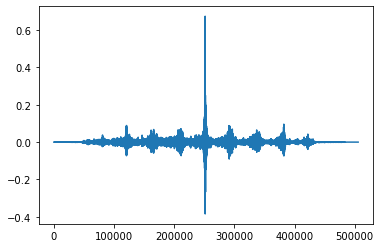

In [562]:
corr_1d = corr(orgdata, bfdata)
corr_1d
pp.plot(corr_1d)

#### Error evalution

In [563]:
# evaluate by calculating the errors
def error(orgdata, bfdata):
    # Normalize data
    orgnorm = orgdata/np.linalg.norm(orgdata)
    bfnorm = bfdata/np.linalg.norm(bfdata)
    length = min(len(orgnorm), len(bfnorm))
    error = ((orgnorm[:length] - bfnorm[:length]) ** 2).mean() ** 0.5
    return error

In [564]:
## 11 mics
err_1d = error(orgdata, bfdata)
err_1d

0.002844288321552326

In [565]:
## error of mixdata
err_mix = error(orgdata, mixdata)
err_mix

0.0029487991410663728

---

#### SNR evalution

In [492]:
# calculate signal to noise ratio 
def SNR(orgdata, bfdata):
    # Normalize data
    orgnorm = orgdata/np.linalg.norm(orgdata)
    bfnorm = bfdata/np.linalg.norm(bfdata)
    length = min(len(orgnorm), len(bfnorm))
    est_noise = orgnorm[:length] - bfnorm[:length]
    snr = 10 * np.log10((np.sum(orgnorm)**2))/(np.sum(est_noise)**2)
    return snr

In [493]:
SNR(orgdata, bfdata)

-56734.27855144817

In [ ]:
    norm = singleChannel / (max(numpy.amax(singleChannel), -1 * numpy.amin(singleChannel)))


In [13]:
# calculate signal to noise ratio 
def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    #return np.where(sd == 0, 0, me/sd)
    return 20*np.log10(abs(np.where(sd == 0, 0, me/sd)))

snr_1d = signaltonoise(bfdata, axis=0, ddof=0)
snr_1d

-90.25095502135815

In [15]:
snr_1d_mix = signaltonoise(mixdata, axis=0, ddof=0)
snr_1d_mix

-92.27144266659056

---

#### RMS evalution

In [22]:
# Compute the RMS ratio of the noise to the RMS of the original data (hello data).
orgdata = hello.data.flatten().astype('float')
bfdata = bfdata.flatten().astype('float')[:len(orgdata)]

# Normalize data
orgnorm = orgdata/np.linalg.norm(orgdata)
bfnorm = bfdata/np.linalg.norm(bfdata)


rms_noise = ((orgnorm - bfnorm) ** 2).mean() ** 0.5
rms_signal = ((orgnorm) ** 2).mean() ** 0.5
score = 1 - rms_noise / rms_signal
print("Your score: %.5f" % score)

Your score: -0.44371


----

### 2-D mics

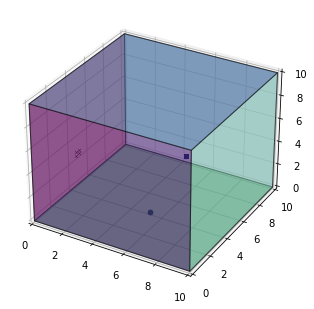

In [23]:
'''Room Parameters and Room Creation'''
room_dim = [10, 10, 10] # meters
m = pra.Material(energy_absorption="panel_fabric_covered_6pcf")
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=m, max_order=0) #simulate perfect situation: no reflections

'''Sound Source Creation'''
room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1) # inference 2?

'''Mic Array Creation'''
mic_locs = np.c_[
    [1, 3, 4],
    [1, 3, 4.3],
    [1, 3.3, 4],
    [1, 3.3, 4.3]
    
#     [1, 3, 4],
#     [1, 3.5, 5],
#     [1, 5, 4],
#     [1, 5.5, 5]
#     [1, 4.9, 5],
#     [1, 5, 5],
#     [1, 5.1, 5],
#     [1, 5.2, 5],
#     [1, 5.3, 5],
#     [1, 5.4, 5],
#     [1, 5.5, 5]
]


# filter size (???)
Lg_t = 0.1 # filter size in seconds
Lg = np.ceil(Lg_t*room.fs)


# place the beamforming micarray in the room (the beamforming class is a child class of the micarray class)
fft_len = 512
mics = pra.Beamformer(mic_locs, room.fs, N=fft_len, Lg=Lg)
room.add_microphone_array(mics)


# Compute DAS (delay and sum) weights
mics.rake_delay_and_sum_weights(room.sources[0])

'''Simulation'''
room.compute_rir()
room.simulate()


fig, ax = room.plot()

In [24]:
### Original_mixed ###
original_signal = room.mic_array.signals[0, :]
Audio(original_signal, room.fs).play()

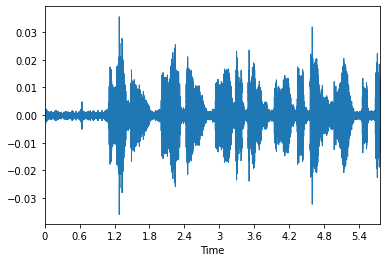

In [26]:
Audio(original_signal, room.fs).plot_wave()

In [25]:
### Beamformed ###
resulted_signal = mics.process()
bfdata = Audio(resulted_signal, room.fs).data
Audio(resulted_signal, room.fs).play()

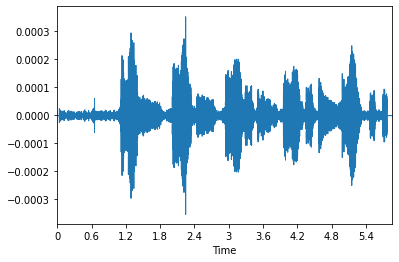

In [27]:
Audio(resulted_signal, room.fs).plot_wave()

### evaluation

In [29]:
## [1,1,1,1,1]
err_2d = error(orgdata, bfdata)
err_2d

0.002880038563759298

In [35]:
## [6,6,6,6,6]
err_2d = error(orgdata, hello.data)
err_2d

7.01649587650003e-09

---

In [36]:
# calculate signal to noise ratio 
def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    #return np.where(sd == 0, 0, me/sd)
    return 20*np.log10(abs(np.where(sd == 0, 0, me/sd)))

snr_2d = signaltonoise(bfdata, axis=0, ddof=0)
snr_2d

-89.102851855516

---

### spherical mics

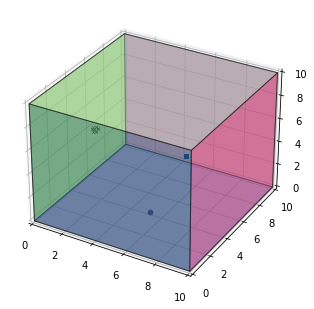

In [40]:
'''Room Parameters and Room Creation'''
room_dim = [10, 10, 10] # meters
m = pra.Material(energy_absorption="panel_fabric_covered_6pcf")
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=m, max_order=0) #simulate perfect situation: no reflections

'''Sound Source Creation'''
room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1) # inference 2?

'''Mic Array Creation'''
# center of array as column vector
mic_center = np.c_[[1, 5, 5]]

# microphone array radius
mic_radius = 0.2

# number of elements
mic_n = 12

# The GridSphere objects creates a number of points
# pseudo-uniformly spread on the unit sphere
grid = pra.doa.GridSphere(mic_n)

# The locations of the microphones can then be computed
R = mic_center + mic_radius * grid.cartesian

'''filter size'''
# filter size (???)
Lg_t = 0.1 # filter size in seconds
Lg = np.ceil(Lg_t*room.fs)

# Finally, we make the microphone array object as usual
# second argument is the sampling frequency
# place the beamforming micarray in the room (the beamforming class is a child class of the micarray class)
fft_len = 512

mics = pra.Beamformer(R, room.fs, N=fft_len, Lg=Lg)
room.add_microphone_array(mics)

#mics_ = pra.MicrophoneArray(R, room.fs)


# Compute DAS (delay and sum) weights
mics.rake_delay_and_sum_weights(room.sources[0])

'''Simulation'''
room.compute_rir()
room.simulate()


fig, ax = room.plot()

In [41]:
### Original_mixed ###
original_signal = room.mic_array.signals[0, :]
Audio(original_signal, room.fs).play()

In [42]:
### Beamformed ###
resulted_signal = mics.process()
bfdata = Audio(resulted_signal, room.fs).data
Audio(resulted_signal, room.fs).play()

### evaluation

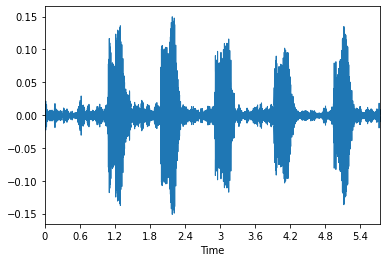

In [43]:
## hello.wav
hello.plot_wave()

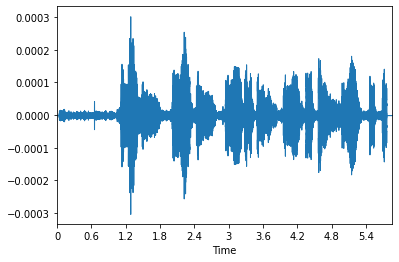

In [44]:
## BF
Audio(resulted_signal, room.fs).plot_wave()

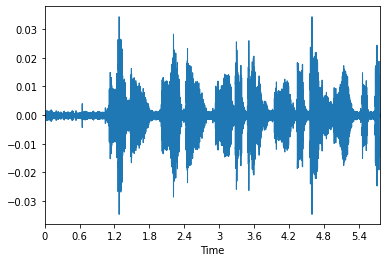

In [45]:
## Mix
Audio(original_signal, room.fs).plot_wave()

In [46]:
err_3d = error(orgdata, bfdata)
err_3d

0.0028594240961344673

In [47]:
err_1d, err_2d, err_3d

(7.01649587650003e-09, 7.01649587650003e-09, 0.0028594240961344673)

---

In [48]:
# calculate signal to noise ratio 
def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    #return np.where(sd == 0, 0, me/sd)
    return 20*np.log10(abs(np.where(sd == 0, 0, me/sd)))

snr_3d = signaltonoise(bfdata, axis=0, ddof=0)
snr_3d

-91.47367071400225